# LSTM을 활용한 주가 예측

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

"""alpha_vantage는 REST 형식으로 미국 주식 정보를 제공하고 있다."""
from alpha_vantage.timeseries import TimeSeries 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
"""서버 및 개발환경 정의"""

config = {
    "alpha_vantage": {
        "key": "HF3WOXMB5Q8P8I79", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "4. close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cuda", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

----

### 데이터 불러오기

In [6]:
"""기존에 참고했던 코드에서 ts.get_daily_adjusted() 부분과 config["alpha_vantage"]["key_adjusted_close"] 부분이 에러가 나기에 수정하였다."""

def download_data(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"]) # config dict 안의 API key 불러오기
    data, meta_data = ts.get_daily(config["alpha_vantage"]["symbol"], outputsize = config["alpha_vantage"]["outputsize"])
    
    data_date = [date for date in data.keys()]
    data_date.reverse()
    
    ## 딕셔너리의 key는 인덱싱이 안 되기에 for문으로 하나씩 불러와야한다.
    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()] 
    # 순서대로 정렬
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)
    
    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)
    
    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config)

Number data points 5648 from 1999-11-01 to 2022-04-11


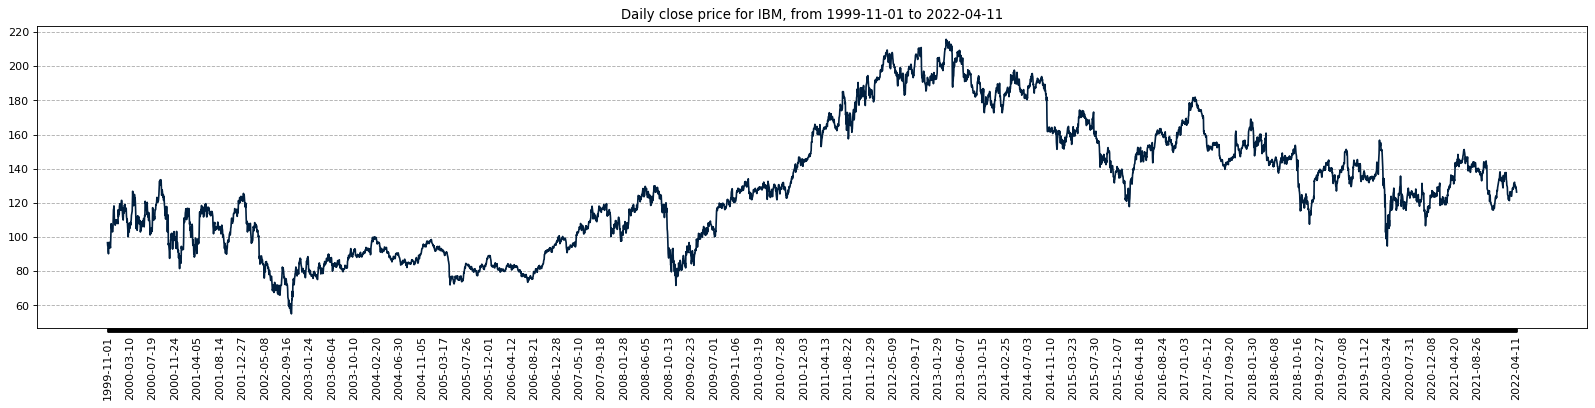

In [7]:
"""plotting"""

# dpi는 해상도를 설정 -> 높을수록 높은 해상도를 가짐
fig = figure(figsize=(25, 5), dpi=80)

## 이미 생성되어 있는 figure를 대상으로 멤버함수를 호출한다.
    # fig.set_size_inches(10,5)
    # fig.patch.set_facecolor("white") -> 사용하는 환경에 따라 figure의 face color가 gray로 설정되는 경우가 있기에 강제로 white로 지정하는 것이 좋다.
fig.patch.set_facecolor((1.0, 1.0, 1.0)) # RGB 값을 설정하는 게 아닐까?
plt.plot(data_date, data_close_price, color = config["plots"]["color_actual"])

# xticks를 이상적인 구도로 맞추기 위해 조정
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)]
x = np.arange(0, len(xticks))

## plt.xticks(num_list, label) : 첫 num은 리스트의 형태로 몇 개의 값이 x축으로 들어갈 것인지 설정, 이후 각 x값에 어떤 label이 들어가는지 설정
plt.xticks(x, xticks, rotation="vertical")
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(b = None, which = 'major', axis = 'y', linestyle='--')
plt.show()

----

### Normalization

In [8]:
"""정규화 함수"""
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None
        
    ## 정규화 하기
    def fit_transform(self, x):
        ## 행별로 평균 구하기 (이 경우에 넘파이 어레이가 하나밖에 없기에 axis를 안 넣어줘도 된다.)
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x-self.mu)/(self.sd)
        return normalized_x
    
    ## 정규화 해제
    def inverse_transform(self, x):
        return (x*self.sd) + self.mu
    
# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

---

### Training dataset과 Validation dataset 구하기
- 본 코드 연습에서는 train 기간을 20일로 잡겠다. 이유는 다음과 같다.
    1. NLP에서 LSTM이 사용될 때, 한 문장의 단어는 보통 15~20개이다.
    2. sequence가 너무 길면 vanishing gradient가 발생한다.
    3. 긴 sequence는 training 시간이 더 많이 걸린다.
- 1일부터 20일치 traing data // 21일 = testing data
- 위와 같이 데이터를 바꿔보면 x의 행과 y의 개수는 같아진다.

In [9]:
"""20일치 train, 21일은 label"""

def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size +1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    output = x[window_size:]
    return output

In [10]:
data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size = config['data']['window_size'])
data_y = prepare_data_y(normalized_data_close_price, window_size = config['data']['window_size'])

In [11]:
"""split data"""
split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

In [12]:
"""prepare data for plotting"""
## train data와 val data의 real y 값 plotting
to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

## 정규화를 해제한 후 값 넣기
    # plotting을 할 때, 전체 data에서 [window_size:split_index+window_size]만큼 해주는 이유는 멘 앞의 window_size만큼은 구할 수 없기 때문이다. 
to_plot_data_y_train[config["data"]["window_size"]:split_index+config['data']['window_size']] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[split_index+config['data']['window_size']:] = scaler.inverse_transform(data_y_val)

## np.where에서 몇 번째 위치가 조건을 만족하는가
    # np.where(a > 10, a, 10) # a가 10보다 크면 그대로, 그렇지 않으면 10으로 설정 (a는 array)
to_plot_data_y_train = np.where(to_plot_data_y_train==0, None, to_plot_data_y_train) # to_plot_data_y_train가 0이면 None으로 그렇지 않으면 to_plot_data_y_train으로 표기
to_plot_data_y_val = np.where(to_plot_data_y_val==0, None, to_plot_data_y_val)

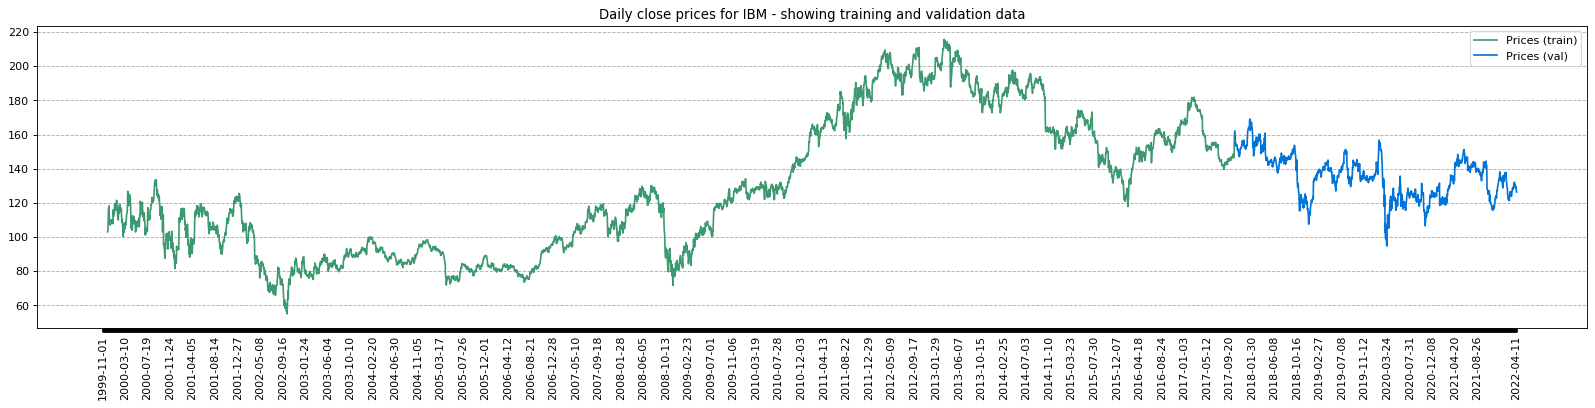

In [13]:
"""plotting"""
fig = figure(figsize = (25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

### val 부분에서 train 기간의 값들이 None이 아닌 0이라면 그래프가 이상하게 표시된다.
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label = "Prices (val)", color = config["plots"]["color_val"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)]
x = np.arange(0, len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config['alpha_vantage']["symbol"] + " - showing training and validation data")
plt.grid(b = None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

### pytorch data loading

In [14]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        
        ## np.expand_dims(x, 2) : 2번째 축에 차원을 추가 -> x[np.newaxis,:] 등으로도 추가할 수 있다.
            # 기존의 data_x_train의 차원 = (4501, 20) -> expand_dim() 후에는 (4501, 20, 1)이 된다. 바로 밑에서 설명하는 형식에 맞춤
        x = np.expand_dims(x, 2) # feature가 하나밖에 없기에 [batch, sequence, features]로 x를 바꾼다.
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
      
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (4502, 20, 1) (4502,)
Validation data shape (1126, 20, 1) (1126,)


In [15]:
"""pytorch의 DataLoader() 사용"""
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]['batch_size'], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

In [17]:
## 한 번에 모든 데이터를 가져오는 게 아니라 batch size만큼만 가져옴
for idx, (x, y) in enumerate(train_dataloader):
    if idx==0:
        print(x.shape)
    else:
        break

torch.Size([64, 20, 1])


----

### LSTM 모델 정의
- LSTM은 데이터의 과거 시퀀스에서 팬턴을 기억하고 미래 사건에 대한 패턴을 외삽할 수 있는 특수 인공 신경망 구조
- linear 1: input 값들을 고차원의 feature space로 매핑 (LSTM layer로 보냄)
- LSTM: 시퀀스 데이터 학습
- linear2: LSTM output으로 부터 예측값 생성

In [190]:
""" LSTM 모델 정의 """
class LSTMModel(nn.Module):
    ## input size는 feature size가 들어간다. 이 경우에 feature는 한 개이므로 1이 들어간다.
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size = self.hidden_layer_size, num_layers = num_layers, batch_first = True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()
        
    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def forward(self, x):
        batchsize = x.shape[0]
        
        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # reshape output from hidden cell into [batch, features] for 'linear_2'
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:, -1]

---

### training

In [191]:
def run_epoch(dataloader, is_training = False):
    epoch_loss = 0
    
    if is_training:
        model.train()
    else:
        # model.eval()을 사용하면 dropout, batch normalization 등의 기능이 비활성화된다.
        model.eval()
        
    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()
            
        batchsize = x.shape[0]
        
        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])
        
        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())
        
        if is_training:
            loss.backward()
            optimizer.step()
        
        epoch_loss += (loss.detach().item()/ batchsize)
        
    lr = scheduler.get_last_lr()[0]
    
    return epoch_loss, lr


train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

## 모델 정의
model = LSTMModel(input_size = config["model"]["input_size"], hidden_layer_size = config["model"]["lstm_size"], num_layers = config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
## 모델 장치 설정
model = model.to(config["training"]["device"])

## 손실함수 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)

## 최적값에 가까워질수록 learning rate를 바꿔주는 값
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

In [192]:
for epoch in range(config['training']['num_epoch']):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/100] | loss train:0.075953, test:0.001791 | lr:0.010000
Epoch[2/100] | loss train:0.020973, test:0.001779 | lr:0.010000
Epoch[3/100] | loss train:0.014923, test:0.001369 | lr:0.010000
Epoch[4/100] | loss train:0.012400, test:0.001343 | lr:0.010000
Epoch[5/100] | loss train:0.013481, test:0.001540 | lr:0.010000
Epoch[6/100] | loss train:0.012077, test:0.001168 | lr:0.010000
Epoch[7/100] | loss train:0.013020, test:0.001164 | lr:0.010000
Epoch[8/100] | loss train:0.011932, test:0.001290 | lr:0.010000
Epoch[9/100] | loss train:0.012462, test:0.001691 | lr:0.010000
Epoch[10/100] | loss train:0.011347, test:0.001283 | lr:0.010000
Epoch[11/100] | loss train:0.012005, test:0.001471 | lr:0.010000
Epoch[12/100] | loss train:0.011299, test:0.001464 | lr:0.010000
Epoch[13/100] | loss train:0.013197, test:0.001115 | lr:0.010000
Epoch[14/100] | loss train:0.011334, test:0.001331 | lr:0.010000
Epoch[15/100] | loss train:0.010417, test:0.001476 | lr:0.010000
Epoch[16/100] | loss train:0.01095

-----

### model evaluation

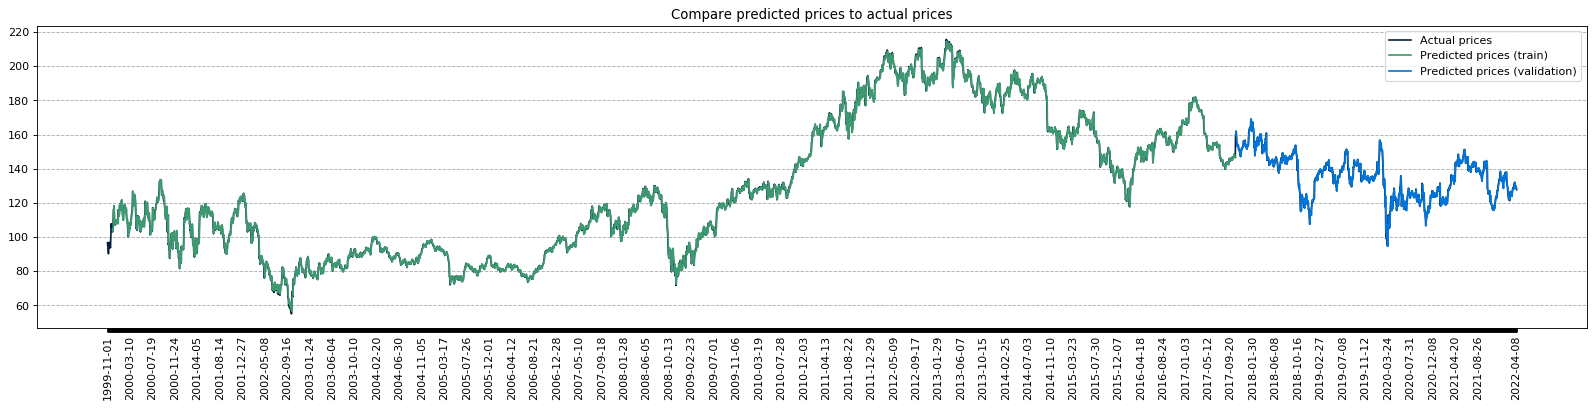

In [193]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()


""" predict on the training data, to see how well the model managed to learn and memorize """
predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"]) # input 되는 데이터 장치에 올리기
    out = model(x) # 모델에 넣기
    out = out.cpu().detach().numpy() # 넘파이 변환을 위해 cpu로 변환
    predicted_train = np.concatenate((predicted_train, out)) # 비어있던 array에 쌓기
    
    
""" predict on the validation data, to see how the model does """
predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out)) # 비어있던 array에 쌓기
    
    
""" prepare data for plotting """
to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

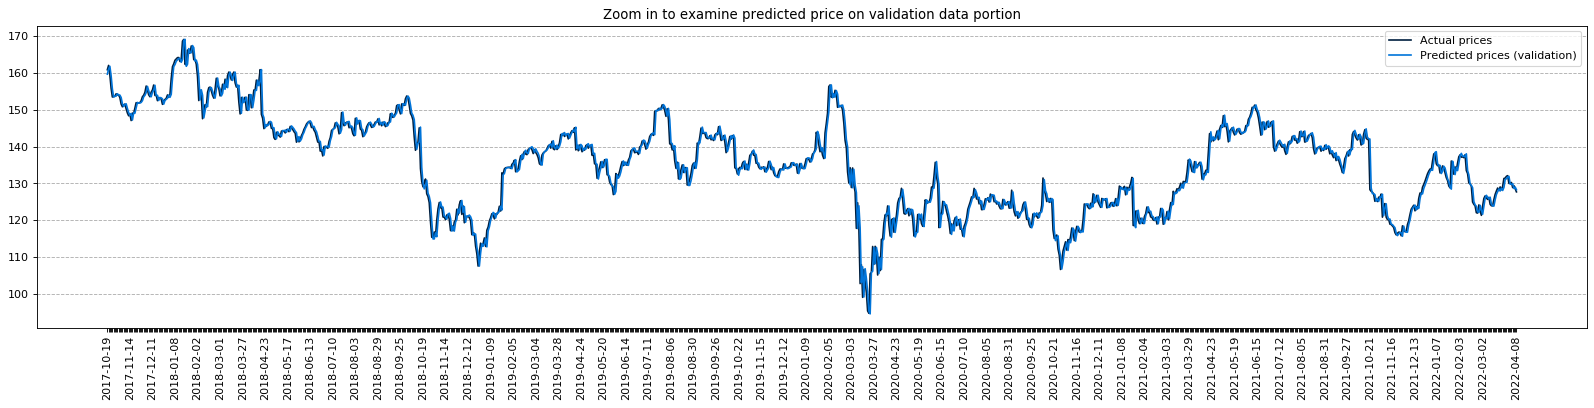

In [194]:

to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
to_plot_predicted_val = scaler.inverse_transform(predicted_val)
to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Zoom in to examine predicted price on validation data portion")
xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
xs = np.arange(0,len(xticks))
plt.xticks(xs, xticks, rotation='vertical')
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

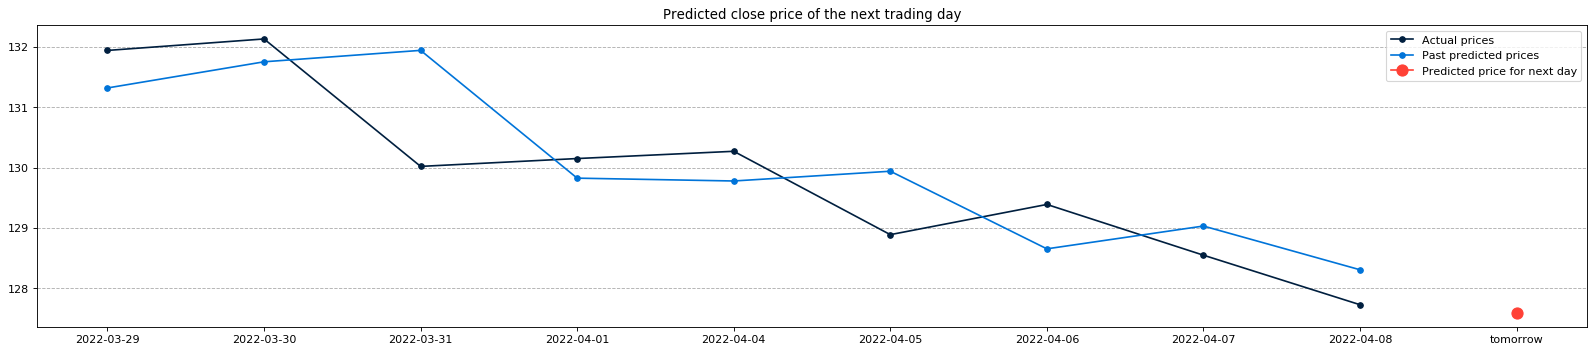

Predicted close price of the next trading day: 127.58


In [195]:
model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()

# prepare plots

plot_range = 10
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)

to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# plot

plot_date_test = data_date[-plot_range+1:]
plot_date_test.append("tomorrow")

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
plt.title("Predicted close price of the next trading day")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

print("Predicted close price of the next trading day:", round(to_plot_data_y_test_pred[plot_range-1], 2))